## Experiment Discription

In this experiment, we use fixed layers. We are trying to change $\frac{\alpha}{\beta}$ and ratio style images and see the effect on different styles.

In [1]:
# neural style transfer structure
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv




device = 'cuda' if torch.cuda.is_available() else 'cpu' 




def getimage(image_path,image_size=(512,512)):
    transform = tv.transforms.Compose([
            tv.transforms.Resize(image_size),
            tv.transforms.ToTensor(),
            ])
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img[None,:,:,:]
    return img.to(device, torch.float)




def myimshow(image,title,save=False,ax=plt):
    fig=plt.figure()  
    image = image.squeeze(0) 
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    h = ax.imshow(image) 
    ax.axis('off') 
    
    if save:
        fig.savefig('{}.jpg'.format(title))
    return h,image

class NormalizeModule(nn.Module):
    def __init__(self):
        super(NormalizeModule, self).__init__()
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)

    def forward(self, x):
        f = (x - self.mean) / self.std
        return f


class ClossModule(nn.Module):

    def __init__(self, f_content,):
        super(ClossModule, self).__init__()
        self.f_content = f_content.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.f_content)/2
        return x

def gram_matrix(x):
        B, N, W, H = x.size()  
        f = x.view(B*N, W*H)  
        G = torch.mm(f, f.t())/(2*B*N*W*H)  
        return G


class SlossModule(nn.Module):

    def __init__(self, f_style):
        super(SlossModule, self).__init__()
        self.G_style = gram_matrix(f_style).detach()

    def forward(self, x):
        G_input = gram_matrix(x)
        self.loss = F.mse_loss(G_input, self.G_style)
        return x




def getmodel(style_img, content_img,content_layers,style_layers):
    
    vgg = tv.models.vgg19(pretrained=True).features.to(device)
    
    model = nn.Sequential()
    model.add_module('Normalization', NormalizeModule().to(device))

    i = 0  
    j = 0
    m = 0
    n = 0
    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'Conv_{}'.format(i)
        else:
            if isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
            j += 1
            name = 'Notconv_{}'.format(j)

        model.add_module(name, layer)

        if name[5:] in str(content_layers):
            m += 1
            f_content = model(content_img).detach()
            Closs = ClossModule(f_content)
            model.add_module("Closs_{}".format(m), Closs)
          

        if name[5:] in str(style_layers):
            n += 1
            f_style = model(style_img).detach()
            Sloss = SlossModule(f_style)
            model.add_module("Sloss_{}".format(n), Sloss)
            
        if m==len(content_layers) and n==len(style_layers):
            break
    return model



def nst(input_img,content_img, style_img,
                       content_layers,style_layers,
                       style_weight=1000000, content_weight=1,tol=np.inf,T=3000):
    
    model = getmodel(style_img, content_img,content_layers,style_layers)
    optimizer = torch.optim.Adam([input_img.requires_grad_()])
    n_active = len(style_layers)
    epoch=0
    running_loss=np.inf
    while epoch<T or running_loss>tol:
        
        optimizer.zero_grad()
        model(input_img)
        style_loss = 0
        content_loss = 0

        for name, module in model.named_children():
            if 'Sloss' in name:
                style_loss += module.loss
            if 'Closs' in name:
                content_loss += module.loss

        loss = style_weight*style_loss/n_active + content_weight*content_loss
        loss.backward()

        optimizer.step()
        
        
        running_loss = loss.item()
        if epoch % 300 == 0:
            print("epoch : {}:".format(epoch))
            print('Weighted Loss : {}'.format(running_loss))
        epoch += 1
    input_img.data.clamp_(0, 1)
    return input_img

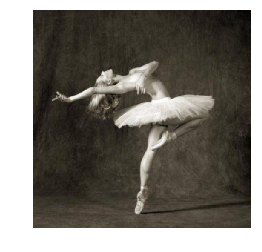

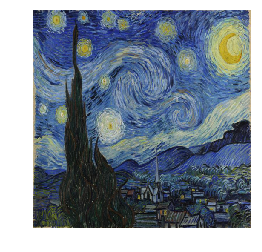

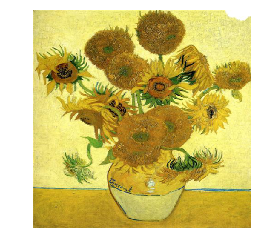

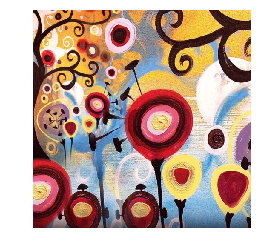

In [2]:
# style_img = getimage('./images/the-starry-night.jpg!Large.jpeg')
style_imgs = ['starry.jpg', 'style2.jpg', 'style3.jpg']
titles = ['starry_night', 'candy',  'sunflowers']
content_img = getimage('dancing.jpg')
# myimshow(style_img,'style_img')
_,_=myimshow(content_img,'content_img')
for i in range(3):
    style_img = getimage(style_imgs[i])
    _,_=myimshow(style_img,titles[i])
    



In [3]:
content_layers_0 = [4]
style_layers_4 = [1,2,3,4]

### 1. ratio  = 1e-6

In [4]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 24.48424530029297
epoch : 300:
Weighted Loss : 3.354753017425537
epoch : 600:
Weighted Loss : 2.459794759750366
epoch : 900:
Weighted Loss : 2.2863402366638184
epoch : 1200:
Weighted Loss : 2.232898473739624
epoch : 1500:
Weighted Loss : 2.2037603855133057
epoch : 1800:
Weighted Loss : 2.1844024658203125
epoch : 2100:
Weighted Loss : 2.1702890396118164
epoch : 2400:
Weighted Loss : 2.15938663482666
epoch : 2700:
Weighted Loss : 2.1506307125091553


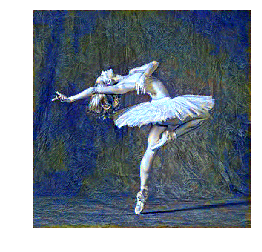

In [5]:
style_img = getimage(style_imgs[0])
output_1_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
_,op11=myimshow(output_1_exp1.detach(),titles[0],save=True)

In [6]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 22.465618133544922
epoch : 300:
Weighted Loss : 3.9001171588897705
epoch : 600:
Weighted Loss : 2.6381454467773438
epoch : 900:
Weighted Loss : 2.238966941833496
epoch : 1200:
Weighted Loss : 1.9818743467330933
epoch : 1500:
Weighted Loss : 1.795703649520874
epoch : 1800:
Weighted Loss : 1.6528141498565674
epoch : 2100:
Weighted Loss : 1.5413175821304321
epoch : 2400:
Weighted Loss : 1.4559518098831177
epoch : 2700:
Weighted Loss : 1.3929096460342407


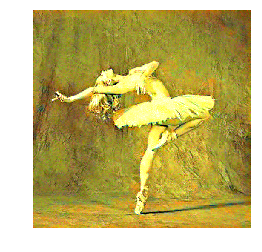

In [7]:
style_img = getimage(style_imgs[1])
output_1_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
_,op12=myimshow(output_1_exp2.detach(),titles[1],save=True)

In [8]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 46.84020233154297
epoch : 300:
Weighted Loss : 6.98770809173584
epoch : 600:
Weighted Loss : 5.204327583312988
epoch : 900:
Weighted Loss : 4.564121246337891
epoch : 1200:
Weighted Loss : 4.281368255615234
epoch : 1500:
Weighted Loss : 4.114751815795898
epoch : 1800:
Weighted Loss : 3.9969422817230225
epoch : 2100:
Weighted Loss : 3.9035205841064453
epoch : 2400:
Weighted Loss : 3.8243250846862793
epoch : 2700:
Weighted Loss : 3.7543091773986816


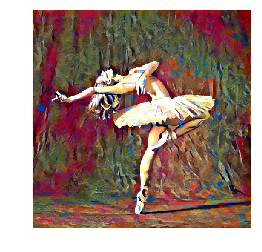

In [9]:
style_img = getimage(style_imgs[2])
output_1_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
_,op13=myimshow(output_1_exp3.detach(),titles[2],save=True)

### 2. ratio = 1e-5

In [10]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 3.1567907333374023
epoch : 300:
Weighted Loss : 1.4266281127929688
epoch : 600:
Weighted Loss : 1.3272508382797241
epoch : 900:
Weighted Loss : 1.304028034210205
epoch : 1200:
Weighted Loss : 1.2929506301879883
epoch : 1500:
Weighted Loss : 1.2861536741256714
epoch : 1800:
Weighted Loss : 1.2814462184906006
epoch : 2100:
Weighted Loss : 1.2779455184936523
epoch : 2400:
Weighted Loss : 1.2751760482788086
epoch : 2700:
Weighted Loss : 1.2729427814483643


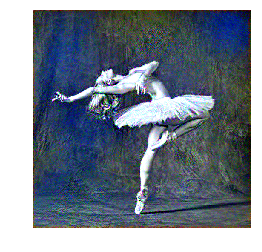

In [11]:
style_img = getimage(style_imgs[0])
output_2_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000, content_weight=1)
_,op21=myimshow(output_2_exp1.detach(),titles[0],save=True)

In [12]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 2.9531896114349365
epoch : 300:
Weighted Loss : 1.019446611404419
epoch : 600:
Weighted Loss : 0.8673210144042969
epoch : 900:
Weighted Loss : 0.8231260776519775
epoch : 1200:
Weighted Loss : 0.7958923578262329
epoch : 1500:
Weighted Loss : 0.7756759524345398
epoch : 1800:
Weighted Loss : 0.7599645853042603
epoch : 2100:
Weighted Loss : 0.7476017475128174
epoch : 2400:
Weighted Loss : 0.738040566444397
epoch : 2700:
Weighted Loss : 0.7308365106582642


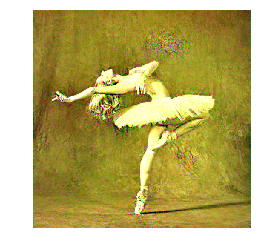

In [13]:
style_img = getimage(style_imgs[1])
output_2_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000, content_weight=1)
_,op22=myimshow(output_2_exp2.detach(),titles[1],save=True)

In [14]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 5.393524169921875
epoch : 300:
Weighted Loss : 2.506436824798584
epoch : 600:
Weighted Loss : 2.3033435344696045
epoch : 900:
Weighted Loss : 2.233994483947754
epoch : 1200:
Weighted Loss : 2.2008438110351562
epoch : 1500:
Weighted Loss : 2.180147647857666
epoch : 1800:
Weighted Loss : 2.1652772426605225
epoch : 2100:
Weighted Loss : 2.1537060737609863
epoch : 2400:
Weighted Loss : 2.144214630126953
epoch : 2700:
Weighted Loss : 2.1362009048461914


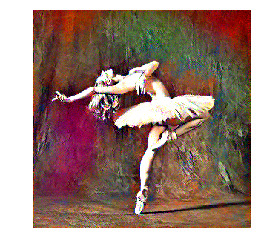

In [15]:
style_img = getimage(style_imgs[2])
output_2_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=100000, content_weight=1)
_,op23=myimshow(output_2_exp3.detach(),titles[2],save=True)

### 3. ratio = 1e-4

In [18]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 1.0214688777923584
epoch : 300:
Weighted Loss : 0.3043665885925293
epoch : 600:
Weighted Loss : 0.300815612077713
epoch : 900:
Weighted Loss : 0.2983105182647705
epoch : 1200:
Weighted Loss : 0.2966148257255554
epoch : 1500:
Weighted Loss : 0.2955789566040039
epoch : 1800:
Weighted Loss : 0.2949032485485077
epoch : 2100:
Weighted Loss : 0.2944004535675049
epoch : 2400:
Weighted Loss : 0.2939600646495819
epoch : 2700:
Weighted Loss : 0.2935665547847748


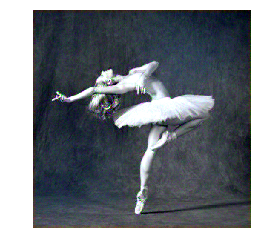

In [19]:
style_img = getimage(style_imgs[0])
output_3_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=10000, content_weight=1)
_,op31=myimshow(output_3_exp1.detach(),titles[0],save=True)

In [20]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 0.9988179206848145
epoch : 300:
Weighted Loss : 0.23157477378845215
epoch : 600:
Weighted Loss : 0.21706995368003845
epoch : 900:
Weighted Loss : 0.21083149313926697
epoch : 1200:
Weighted Loss : 0.20683404803276062
epoch : 1500:
Weighted Loss : 0.2045063078403473
epoch : 1800:
Weighted Loss : 0.20318414270877838
epoch : 2100:
Weighted Loss : 0.20231935381889343
epoch : 2400:
Weighted Loss : 0.2016628086566925
epoch : 2700:
Weighted Loss : 0.20110619068145752


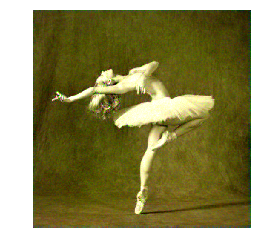

In [21]:
style_img = getimage(style_imgs[1])
output_3_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=10000, content_weight=1)
_,op32=myimshow(output_3_exp2.detach(),titles[1],save=True)

In [22]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 1.2456064224243164
epoch : 300:
Weighted Loss : 0.5426728129386902
epoch : 600:
Weighted Loss : 0.5311607718467712
epoch : 900:
Weighted Loss : 0.522271990776062
epoch : 1200:
Weighted Loss : 0.5163743495941162
epoch : 1500:
Weighted Loss : 0.5128845572471619
epoch : 1800:
Weighted Loss : 0.5105001330375671
epoch : 2100:
Weighted Loss : 0.5088157653808594
epoch : 2400:
Weighted Loss : 0.5073915123939514
epoch : 2700:
Weighted Loss : 0.5062565803527832


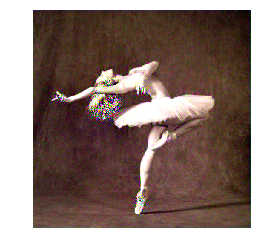

In [23]:
style_img = getimage(style_imgs[2])
output_3_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=10000, content_weight=1)
_,op33=myimshow(output_3_exp3.detach(),titles[2],save=True)

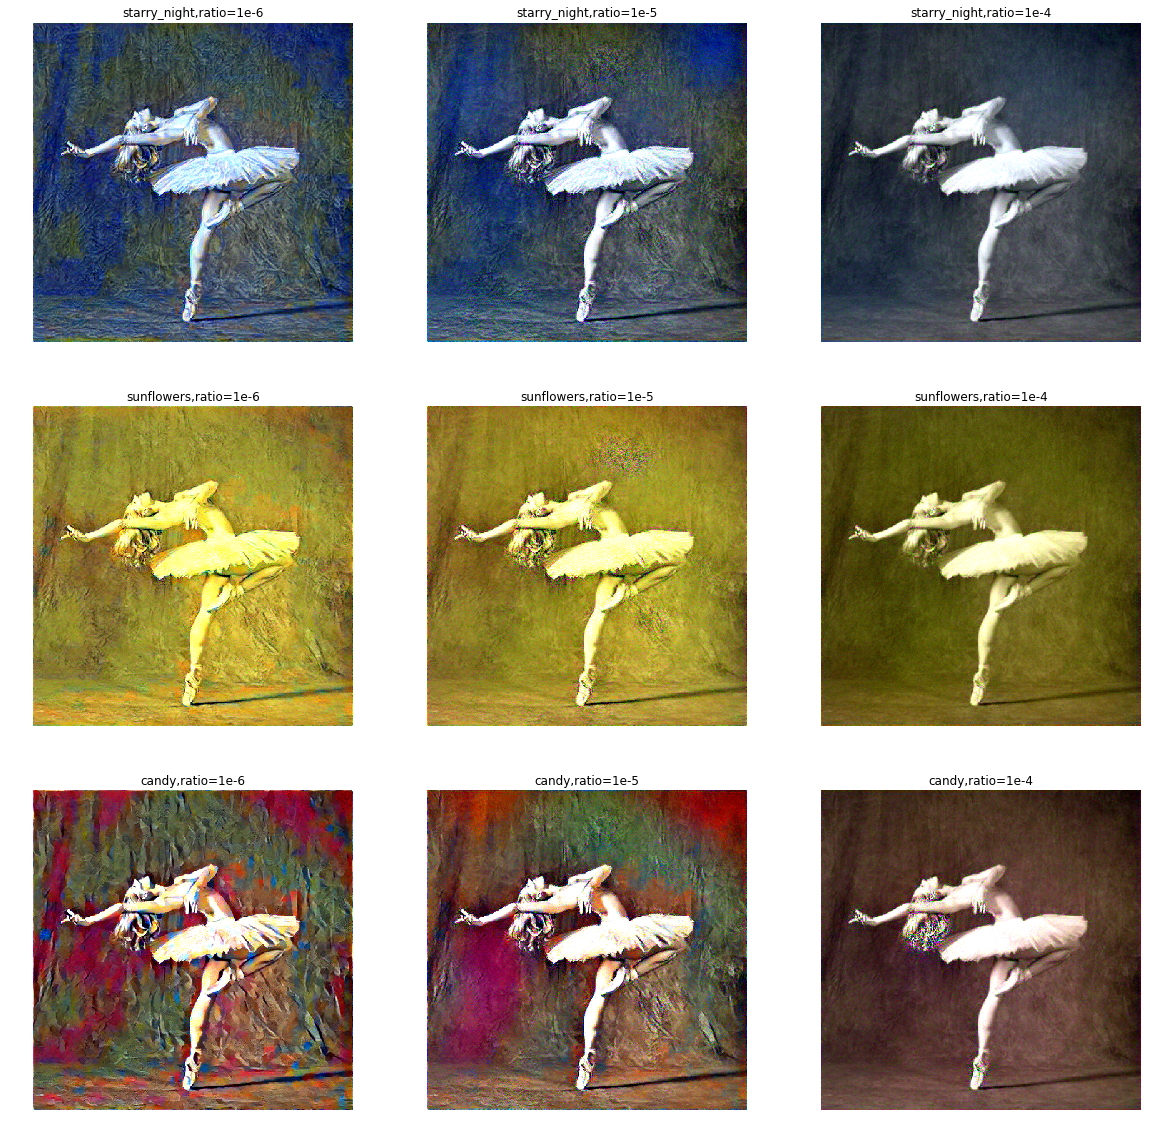

In [29]:
fig, axes = plt.subplots(ncols=3, nrows=3,figsize=(20,20),sharex='all' ,sharey='all')
axes[0][0].imshow(op11) 
axes[0][0].axis('off') 
axes[0][0].set_title('starry_night,ratio=1e-6') 
axes[1][0].imshow(op12) 
axes[1][0].axis('off') 
axes[1][0].set_title('sunflowers,ratio=1e-6')
axes[2][0].imshow(op13) 
axes[2][0].axis('off') 
axes[2][0].set_title('candy,ratio=1e-6')

axes[0][1].imshow(op21) 
axes[0][1].axis('off') 
axes[0][1].set_title('starry_night,ratio=1e-5') 
axes[1][1].imshow(op22) 
axes[1][1].axis('off') 
axes[1][1].set_title('sunflowers,ratio=1e-5')
axes[2][1].imshow(op23) 
axes[2][1].axis('off') 
axes[2][1].set_title('candy,ratio=1e-5')

axes[0][2].imshow(op31) 
axes[0][2].axis('off') 
axes[0][2].set_title('starry_night,ratio=1e-4') 
axes[1][2].imshow(op32) 
axes[1][2].axis('off') 
axes[1][2].set_title('sunflowers,ratio=1e-4')
axes[2][2].imshow(op33) 
axes[2][2].axis('off') 
axes[2][2].set_title('candy,ratio=1e-4')
fig.savefig('realout.jpg')